# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
if False:

    from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                    getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

    from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
         load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
        apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
        create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                            save_arrays, psave_obj,pload_obj, get_non_uniform_edges )


    from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                     plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                    create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                    plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                    circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                    get_angular_mask,save_g2,plot_g2,get_g2_fit,
                                    get_ring_anglar_mask,save_seg_saxs_g2,plot_saxs_rad_ang_g2,
                                    fit_saxs_rad_ang_g2

                                    )


    from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                    get_four_time_from_two_time,rotate_g12q_to_rectangle)

    from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                                 Multifile,get_avg_imgc, get_each_frame_intensityc,
                    get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

    from chxanalys.SAXS import fit_form_factor
    from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
    from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

    from chxanalys.Create_Report import (create_pdf_report, 
                                    create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


    from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
        convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
        save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                      multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4)
    import sys
    import pandas as pds

    %matplotlib notebook

In [60]:

if True:
    from chxanalys_debug.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                               multi_tau_lags)

    from chxanalys_debug.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

    from chxanalys_debug.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 get_angular_mask,save_g2,plot_g2,get_g2_fit,
                                    get_ring_anglar_mask,save_seg_saxs_g2,plot_saxs_rad_ang_g2,
                                    fit_saxs_rad_ang_g2)    



    from chxanalys_debug.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
    from chxanalys_debug.chx_compress_debug import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

    from chxanalys_debug.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

    from chxanalys_debug.SAXS import fit_form_factor
    from chxanalys_debug.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
    from chxanalys_debug.chx_correlationp import (cal_g2p, auto_two_Arrayp)

    from chxanalys_debug.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


    from chxanalys_debug.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)
    
    import sys
    import pandas as pds

    %matplotlib notebook

In [5]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
#%reset

In [6]:
#%%javascript
#var nb = IPython.notebook;
#var kernel = IPython.notebook.kernel;
#var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
#kernel.execute(command);

In [7]:
#print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

## Make a directory for saving results

In [249]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "kyager"  #provide the username to force the results to save in that username folder

username = "colosqui"
date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)



Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/colosqui/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [250]:

uid = '676d2a' #Measurement: S2 flow 750hz 20k xv2=84.77 -80 ul/hr-Hydrophobic
uid = 'ce0d25' #Measurement: S2 flow 750hz 20k xv2=84.77 -40 ul/hr-Hydrophobic


uid='9d0363'   #Measurement: S2 flow 750hz 20k xv2=85.5 -80 ul/hr



uid ='15fd3e' #Measurement: S2 750hz 20k xv2=85.5 -19 ul/hr
uid ='5117f6' #Measurement: S2 750hz 5k xv2=85.7 -19 ul/hr
uid ='1d49de' #Measurement: S2 750hz 5k xv2=85.9 -19 ul/hr
uid ='ac5c32' #Measurement: S2 750hz 5k xv2=86.1 -19 ul/hr
uid ='4cd5cc' #Measurement: S2 750hz 5k xv2=86.3 -19 ul/hr

uid='f4c3a2' #Measurement: S2 750hz 5k xv2=85.5 -10ul/hr
uid='61a9d3' #Measurement: S2 750hz 5k xv2=85.7 -10ul/hr
uid='646de6' #Measurement: S2 750hz 5k xv2=85.9 -10ul/hr
uid='afe773' #Measurement: S2 750hz 5k xv2=86.1 -10ul/hr
uid='7b5053' #Measurement: S2 750hz 5k xv2=86.3 -10ul/hr

uid ='e3de21' #Measurement: S2 flow 750hz 5k xv2=85.5 -40 ul/hr
uid='0c0e08'  #Measurement: S2 flow 750hz 5k xv2=85.7 -40 ul/hr
uid='58b6b5'  #Measurement: S2 flow 750hz 5k xv2=85.9 -40 ul/hr
uid='3ce095'  #Measurement: S2 flow 750hz 5k xv2=86.1 -40 ul/hr
uid='6a0c6e'   #Measurement: S2 flow 750hz 5k xv2=86.3 -40 ul/hr

uid='9d0363'   #Measurement: S2 flow 750hz 20k xv2=85.5 -80 ul/hr
uid ='e3de21' #Measurement: S2 flow 750hz 5k xv2=85.5 -40 ul/hr
uid ='15fd3e' #Measurement: S2 750hz 20k xv2=85.5 -19 ul/hr
uid='f4c3a2' #Measurement: S2 750hz 5k xv2=85.5 -10ul/hr

uid='61a9d3' #Measurement: S2 750hz 5k xv2=85.7 -10ul/hr
uid ='5117f6' #Measurement: S2 750hz 5k xv2=85.7 -19 ul/hr
uid='0c0e08'  #Measurement: S2 flow 750hz 5k xv2=85.7 -40 ul/hr

uid='646de6' #Measurement: S2 750hz 5k xv2=85.9 -10ul/hr
uid ='1d49de' #Measurement: S2 750hz 5k xv2=85.9 -19 ul/hr
uid='58b6b5'  #Measurement: S2 flow 750hz 5k xv2=85.9 -40 ul/hr

uid='afe773' #Measurement: S2 750hz 5k xv2=86.1 -10ul/hr
uid ='ac5c32' #Measurement: S2 750hz 5k xv2=86.1 -19 ul/hr
uid='3ce095'  #Measurement: S2 flow 750hz 5k xv2=86.1 -40 ul/hr

uid='7b5053' #Measurement: S2 750hz 5k xv2=86.3 -10ul/hr
uid ='4cd5cc' #Measurement: S2 750hz 5k xv2=86.3 -19 ul/hr
uid='6a0c6e'   #Measurement: S2 flow 750hz 5k xv2=86.3 -40 ul/hr


#Hydrophobic surfaces

uid = '664620'  #Measurement: S2 flow 750hz 20k xv2=84.77 -20 ul/hr-Hydrophobic
uid = 'ce0d25' #Measurement: S2 flow 750hz 20k xv2=84.77 -40 ul/hr-Hydrophobic
uid='31ae66'  #Measurement: S2 flow 750hz 20k xv2=84.77 -80 ul./hr-Hydrophobic

uid= 'cab4ca'  #Measurement: S2 flow 750hz 5k xv2=84.97 -40 ul/hr-Hydrophobic
uid= '4a1831'  #Measurement: S2 flow 750hz 5k xv2=85.17  -40 ul/hr-Hydrophobic
uid= '633820'  #Measurement: S2 flow 750hz 5k xv2=85.37 -40 ul/hr-Hydropobic
uid= 'b3d6d0'  #Measurement: S2 flow 750hz 5k xv2=85.57 -40 ul/hr-Hydropobic

uid= '30ae3f' #Measurement: S2 flow 750hz 5k xv2=84.97  -80ul/hr-Hydrophobic
uid= 'fd5042' #Measurement: S2 flow 750hz 5k xv2=85.17  -80ul/hr-Hydrophobic
uid= 'cd55a8' #Measurement: S2 flow 750hz 5k xv2=85.37  -80ul/hr-Hydrophobic
uid= '97fb2c' #Measurement: S2 flow 750hz 5k xv2=85.57  -80ul/hr-Hydrophobic





In [252]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/


# Don't Change these lines below here

In [253]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  2254--97fb2cb1-2bff-4de6-9368-c5a1164b9e29--/XF11ID/data/2016/08/26/708c3cd2-d785-4ab5-820e_1721


In [254]:
imgs = load_data( uid, detector, reverse=True  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/08/26/708c3cd2-d785-4ab5-820e_1721_master.h5


In [255]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']  
    #md['sample']= 'SiO2 Colloidal'  #change the sample name if the md['sample'] is wrong
    print( 'The sample is %s' %md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

The sample is Silica S2 hydrophobic cell


In [256]:
print( 'The data are: %s' %imgs )

The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 5000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


## Overwrite Some Metadata if Wrong Input

In [257]:
print( 'The Metadata are: \n%s' %md )

The Metadata are: 
{'x_pixel_size': 7.5000004e-05, 'frame_time': 0.00134, 'count_time': 0.00133, 'y_pixel_size': 7.5000004e-05, 'Measurement': 'S2 flow 750hz 5k xv2=85.57', 'detector_distance': 0.0, 'beam_center_y': 801.0, 'beam_center_x': 1347.0, 'incident_wavelength': 1.2845441, 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'sample': 'Silica S2 hydrophobic cell'}


In [258]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4.84 * 1000      # detector to sample distance (mm)
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'],2167-md['beam_center_y']  ]  
          # center of the speckle pattern
          #assuming it was correctly entered in the eiger css screen


center = [   1342, 2167 - 1364  ]  

center=[center[1], center[0]]
print ('Beam center=', center)



The sample is Silica S2 hydrophobic cell
Exposuretime=0.00133 sec, Acquisition_period=0.00134 sec
Beam center= [803, 1342]


In [259]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir)

In [260]:
setup_pargs

{'Ldet': 4840.0,
 'center': [803, 1342],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2845441,
 'path': '/XF11ID/analysis/2016_3/colosqui/Results/97fb2c/',
 'timeperframe': 0.00134,
 'uid': '97fb2c'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [261]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
#mask_name = 'Aug24_2_mask.npy'

mask_name = 'Aug_flow_mask.npy'
mask_name = 'sep30_flow_new_mask.npy'


<IPython.core.display.Javascript object>


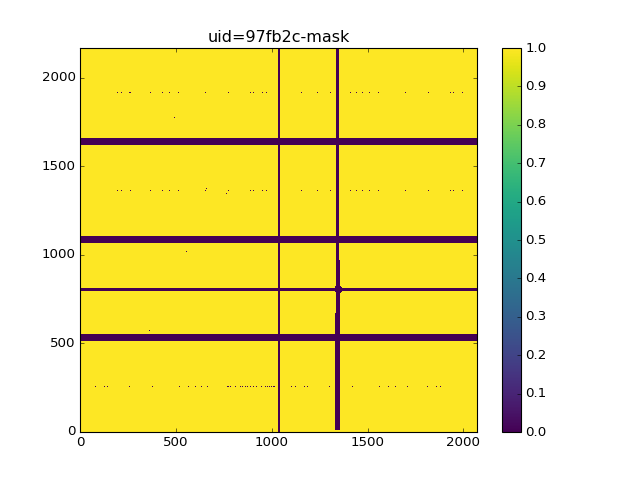

In [262]:
mask = load_mask(mask_path, mask_name, plot_ =  True, reverse=True, image_name = 'uid=%s-mask'%uid )
mask = np.array( mask, dtype = np.int32)

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [263]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = None #NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [264]:
imgsa = apply_mask( imgs, mask )

In [265]:
#show_img( imgsa[0],  vmin= .01, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

<IPython.core.display.Javascript object>


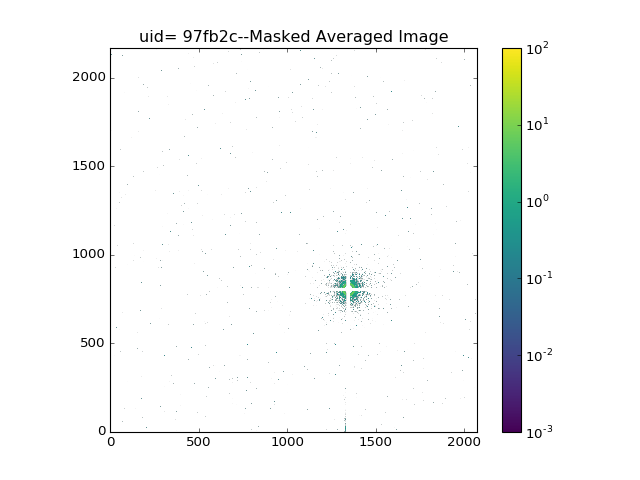

In [266]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

## Determine Compress Or Not

In [270]:
if False:
    photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
    compress =  photon_occ < 1.0  #if the photon ocupation < 0.5, do compress

    print ("The non-zeros photon occupation is %s."%( photon_occ))
    print("Will " + ['NOT', 'DO'][compress]  + " apply compress process.")
compress =True

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [271]:
good_start = 0  #make the good_start at least 0

In [272]:
if False:
    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                    force_compress= False, bad_pixel_threshold= 1e14,nobytes=4,
                                            para_compress=True, num_sub= 10)    

        min_inten = 10    
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, 10,100)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_97fb2cb1-2bff-4de6-9368-c5a1164b9e29.cmp.


Averaging images:   3%|▎         | 142/5000 [00:00<00:03, 1419.57it/s]

hdf5 path = /XF11ID/data/2016/08/26/708c3cd2-d785-4ab5-820e_1721_master.h5


Get each frame intensity: 100%|██████████| 5000/5000 [00:01<00:00, 4715.76it/s]

No bad frames are involved.
The good_start frame number is: 0 


<IPython.core.display.Javascript object>


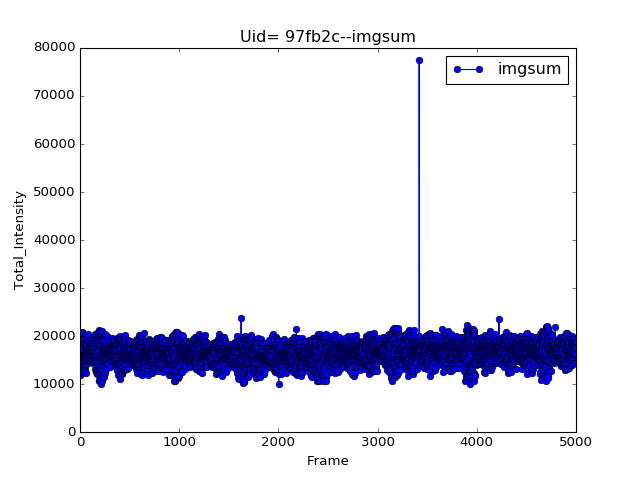

Total time: 0.07 min


In [273]:
t0= time.time()

if True:
    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
        #filename = '/XF11ID/analysis/Compressed_Data/debug' +'/uid_%s.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(uid,  mask, md, filename, 
                        force_compress= False, bad_pixel_threshold= 2.4e18, nobytes=4,
                                            para_compress= True, num_sub= 100, dtypes='uid', reverse=True  )    

        min_inten = 10    
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, good_start,500)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
        
run_time(t0 )

In [275]:
#%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

In [276]:
bad_pixel_threshold= 4e4#1e14  #if re-define a bad pixel threshold
bad_pixel_low_threshold= 0  #if re-define a bad pixel low threshold

In [277]:
if bad_pixel_threshold<1e14:
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                    force_compress=False, bad_pixel_threshold= bad_pixel_threshold,
                bad_pixel_low_threshold=bad_pixel_low_threshold, nobytes=4)
    min_inten = 10
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )   
    
    print ('The good_start frame number is: %s '%good_start)


Averaging images:   3%|▎         | 137/5000 [00:00<00:03, 1368.88it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_97fb2cb1-2bff-4de6-9368-c5a1164b9e29.cmp.


Get each frame intensity: 100%|██████████| 5000/5000 [00:01<00:00, 4622.96it/s]

Bad frame list length is: 1
The good_start frame number is: 0 


## Define a good time series by defining a good start and good end

In [278]:
if False:
        good_start = 0  #0
        good_end =     len(imgs)
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1] 
        FD = Multifile(filename, good_start, good_end)
        avg_img= get_avg_imgc( FD,  beg= None,end=None, plot_=False )
        imgsum,bad_frame_list = get_each_frame_intensityc( FD,  bad_pixel_threshold= 1e14, plot_=False )                           


In [279]:
if not compress:   
    #sampling = 1   #sampling should be one
    sampling = 200  #sampling should be one    
    
    good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )
    print ('The good_start frame number is: %s '%good_start)
    good_series = apply_mask( imgsa[good_start:], mask )
    avg_img =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)
    imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = sampling, 
                                bad_pixel_threshold= 1e14,   plot_ = False, uid=uid)
    
    

In [280]:
#print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))
print ('The good_start frame number is: %s '%good_start)
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list

The number of bad frames is : 1 
The good_start frame number is: 0 


In [281]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'], filename='uid=%s-imgsum'%uid, path= data_dir  )
                            

<IPython.core.display.Javascript object>


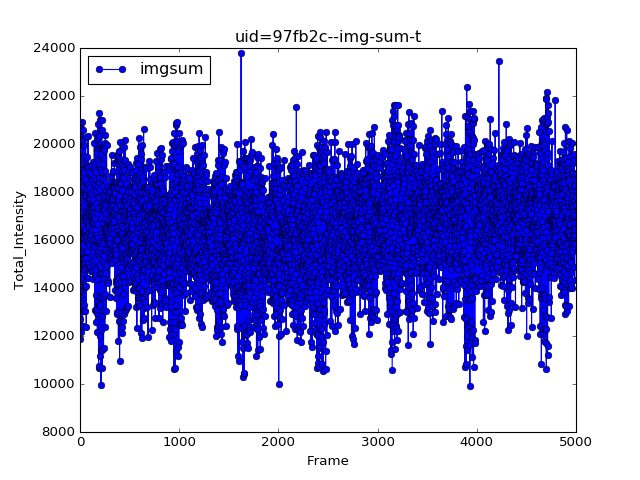

In [282]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Plot intensity average image

<IPython.core.display.Javascript object>


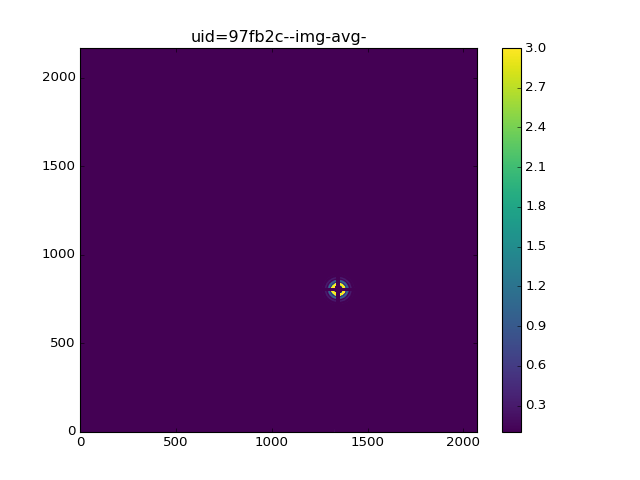

In [292]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid,
        save=True, path=data_dir) 
md['avg_img'] = avg_img

## Get circular average 
* Do plot and save q~iq


In [293]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask

<IPython.core.display.Javascript object>


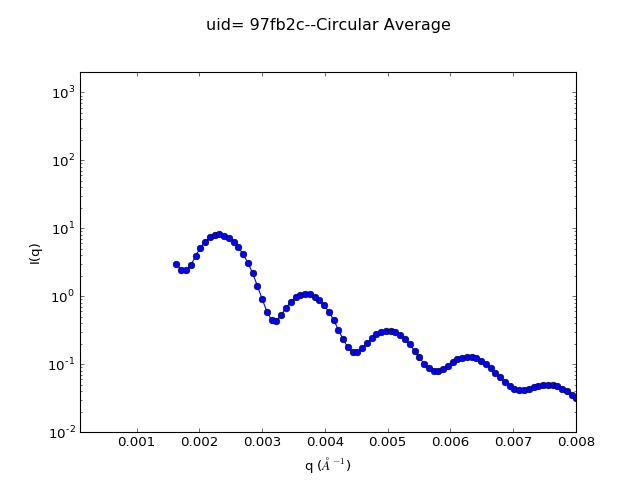

In [294]:
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
                    plot_ = True,show_pixel= False, xlim=[0.0001,.008], ylim = [0.01, 2000], save=True)



# Fit Form Facotr

In [310]:
fit_form = False

In [311]:
if fit_form:
    form_res = fit_form_factor( q,iq,  guess_values={'radius': 2400, 'sigma':0.07, 
         'delta_rho':1E-9 },  fit_range=[0.0001, 0.01], fit_variables={'radius': True, 'sigma':True, 
         'delta_rho':True},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])
    

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [312]:
uniform = False

### Define a non-uniform distributed rings by giving edges

In [313]:
if not uniform:
    #width = 4  # in pixel
    width = 0.0002*5   
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    #centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00759,0.00889] #in A-1 
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [299]:
if uniform:
    
    inner_radius= 0.00205  #16
    outer_radius = 0.00932  #112
    width =  0.0002  #2
    num_rings = 14
    edges = None

In [300]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 



In [301]:
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]


psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters

<IPython.core.display.Javascript object>


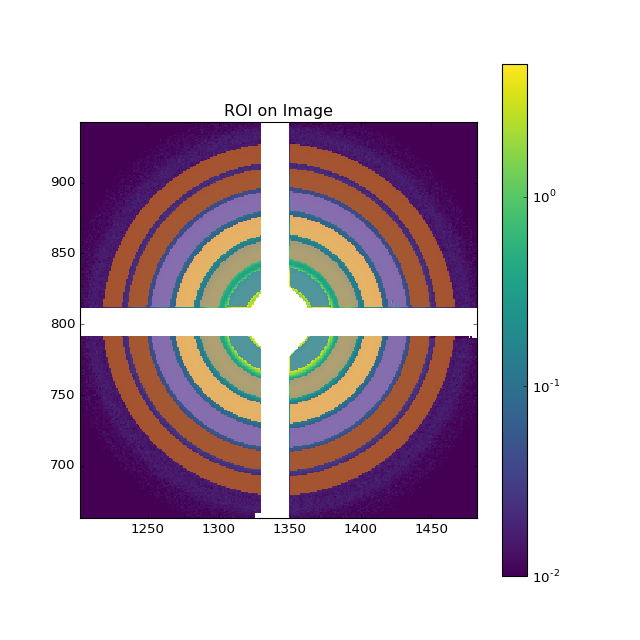

In [302]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=140, alpha=.9,
                 save=True, path=data_dir, uid=uid)

<IPython.core.display.Javascript object>


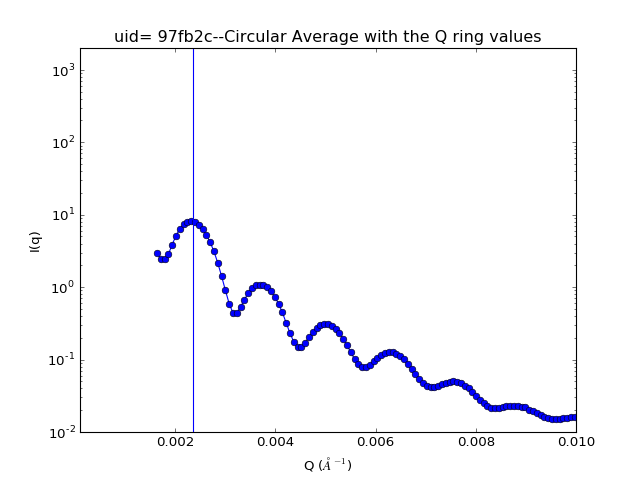

In [314]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.0001,.01],
                  ylim = [0.01, 2000],        save=True, path=data_dir)

## Check one ring intensity

<IPython.core.display.Javascript object>


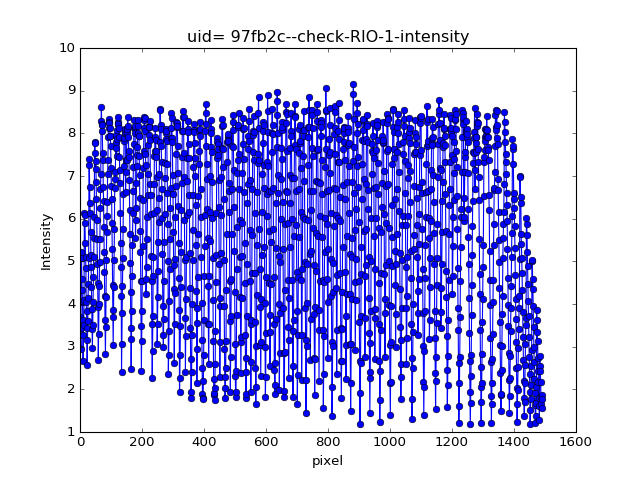

In [315]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 1, uid =uid, save=True, path=data_dir )

## Make angular slices

# Define Qs along a given 'slice'

In [316]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_SAXS.py

In [317]:

inner_angle= 35-.5 +90
outer_angle = 55-.5 +90
num_angles =   20

widtha = (outer_angle - inner_angle )/(num_angles+0.01)

ang_mask, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
                             outer_angle = outer_angle, width = widtha, 
                            num_angles = num_angles, center = center, flow_geometry = True    )

In [318]:
ang_center

array([ 124.99975012,  125.99977643,  126.99980273,  127.99982903,
        128.99985534,  129.99988164,  130.99990794,  131.99993424,
        132.99996055,  133.99998685,  135.00001315,  136.00003945,
        137.00006576,  138.00009206,  139.00011836,  140.00014466,
        141.00017097,  142.00019727,  143.00022357,  144.00024988])

<IPython.core.display.Javascript object>


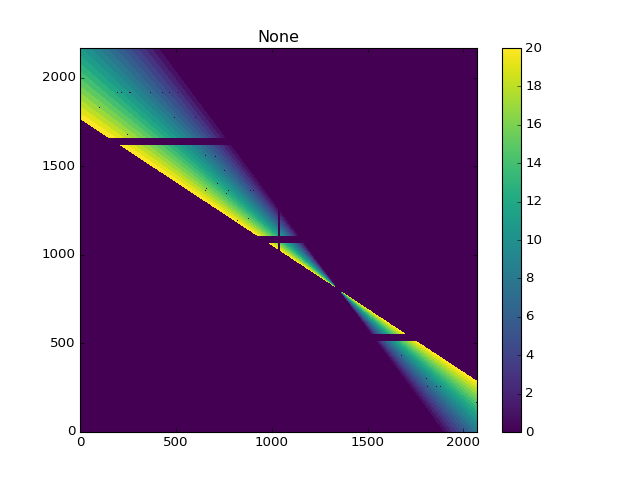

In [319]:
show_img( ang_mask  )


* if define one q

<IPython.core.display.Javascript object>


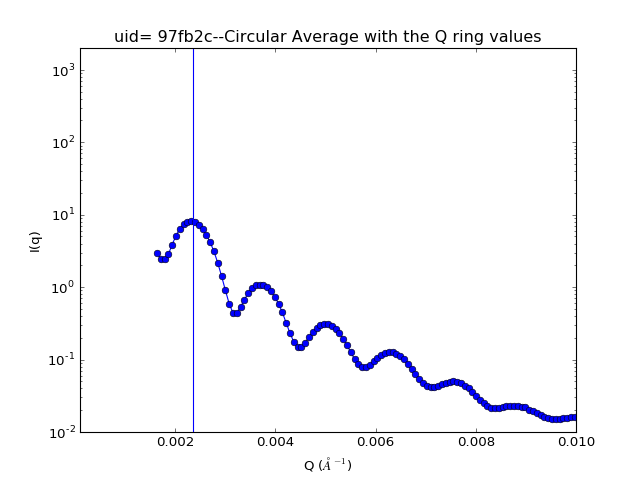

In [320]:
if True:
    width = 0.0002*5    
    number_rings= 1  
    centers = [ 0.00235] #in A-1 
    
    edges = get_non_uniform_edges(  centers, width, number_rings )
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None
    
    ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                    unit='A',outer_radius = outer_radius, 
                    width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  ring_mask  ) 
    
    plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid,
                  ylim = [0.01, 2000] ,xlim=[0.0001,.0100], save=True, path=data_dir)

In [321]:
seg_mask,  rcen, acen = get_ring_anglar_mask( ring_mask, ang_mask, q_ring_center, ang_center)

<IPython.core.display.Javascript object>


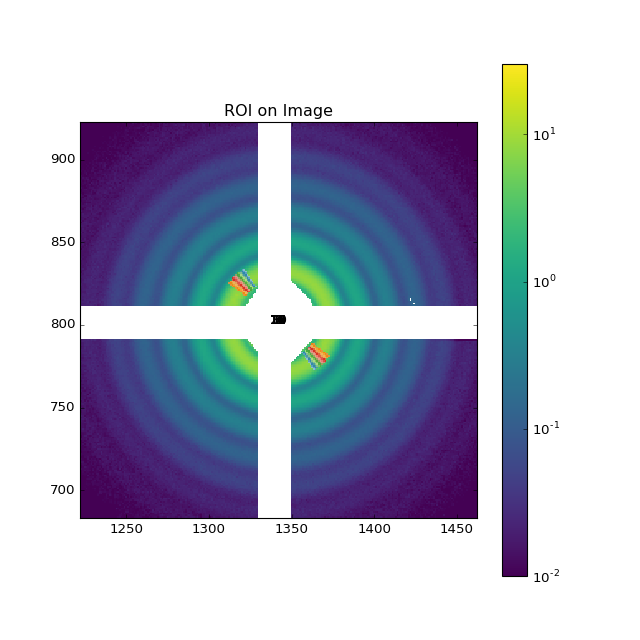

In [322]:
show_ROI_on_image( avg_img, seg_mask, center, label_on = True, rwidth=120, alpha=.9, 
                  vmax=30, save=True, path=data_dir, uid=uid)

# Run time correlation 

### if define another good_series

In [323]:
para_cal =  True  #False #True   #if True to use the parallel calculation


In [324]:
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)
norm=None

In [325]:
qind, pixelist = roi.extract_label_indices(  seg_mask  ) 
noqs = len(np.unique(qind))
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([14, 16, 14, 14, 14, 14, 14, 14, 12, 16, 18, 16, 12, 14, 14, 14, 14,
       14, 14, 16])

In [326]:
t0 = time.time()
if compress:
    if para_cal:
        g2_ma_1q, lag_steps_ma_1q  =cal_g2p( FD,  seg_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
    else:
        g2_ma_1q, lag_steps_ma_1q  =cal_g2c( FD,  seg_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
else:
    bad_image_process = False
    if  len(bad_frame_list):
        bad_image_process = True
    print( bad_image_process  )

    g2_ma_1q, lag_steps_ma_1q  =cal_g2( good_series,  seg_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--11--
Bad frame involved and will be precessed!
4999 frames will be processed...


  0%|          | 0/20 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/20 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 20/20 [00:03<00:00,  5.83it/s]

G2 calculation DONE!
Total time: 0.16 min


In [341]:
taus = lag_steps_ma_1q * timeperframe
res_pargs_ma_1q = dict(taus=taus, q_ring_center=np.unique(rcen), 
                 ang_center= np.unique(acen),  path=data_dir, uid=uid +'_ma_1q'       )

## save g2

In [342]:
save_g2( g2_ma_1q, taus=taus, qr=rcen, qz=acen, uid=uid +'_ma_1q', path= data_dir )

The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/ with filename as uid=97fb2c_ma_1q--g2.csv


### Plot the one time correlation functions

In [344]:
if False:
    plot_g2( g2_ma_1q, res_pargs_ma_1q, geometry='ang_saxs', master_plot='qr', one_plot= True, vlim=[0.95, 1.05], )

# Fit g2

In [345]:
fit=True

if fit:
    g2_ma_1q_fit_result, taus_ma_1q_fit, g2_ma_1q_fit = get_g2_fit( g2_ma_1q,  res_pargs=res_pargs, 
                function = 'stretched_vibration',  vlim=[0.95, 1.05], 
    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                  'freq':True, 'amp':True},
   fit_range= None,                                
    guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,
                 'freq': 60, 'amp':.1})

if fit:
    save_g2( g2_ma_1q_fit, taus=taus_ma_1q_fit, qr=rcen, qz=acen, uid=uid +'_mq_1a_fit', path= data_dir )
    res_pargs_ma_1q_fit = dict(taus=taus_ma_1q_fit, q_ring_center=q_ring_center, 
                 ang_center= acen,  path=data_dir, uid=uid +'_mq_1a_fit'       )
    #save_seg_saxs_g2( data_fit,  res_pargs_fit )

<IPython.core.display.Javascript object>


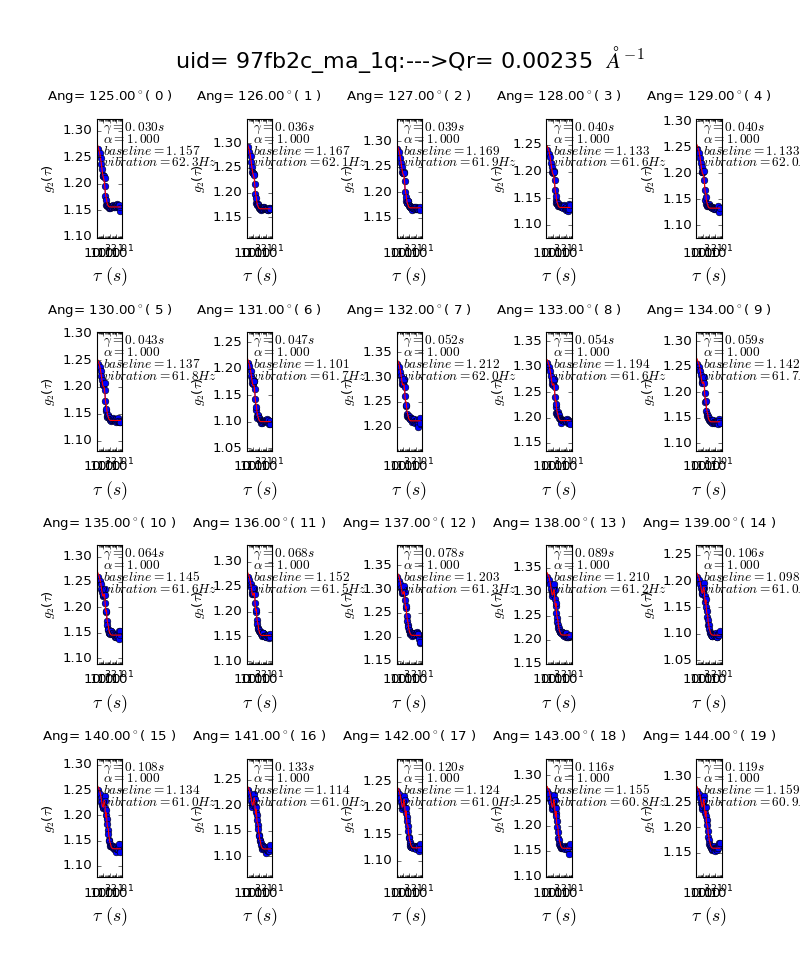

In [348]:
if fit:
    plot_g2( g2_ma_1q, res_pargs=res_pargs_ma_1q, tau_2 = taus_ma_1q_fit, g2_2 = g2_ma_1q_fit,  
        fit_res=g2_ma_1q_fit_result, function = 'stretched_vibration',     
        master_plot = 'qr',vlim=[0.95, 1.05], geometry='ang_saxs'  )

In [349]:
rate_ma_1q = [g2_ma_1q_fit_result[i].best_values['relaxation_rate'] for i in range(len(g2_ma_1q_fit_result))]


<IPython.core.display.Javascript object>


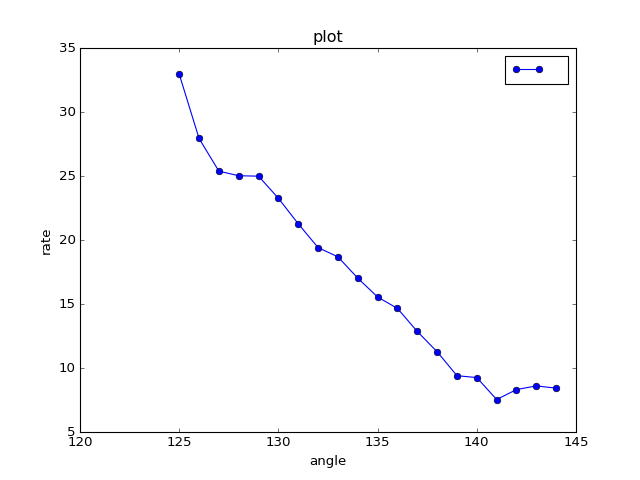

In [350]:
plot1D( x = acen[:], y=rate_ma_1q, xlabel='angle', ylabel='rate')

# get the V-ang is about 132 and P-ang angle is about 42

# For vertical

In [351]:
w = 2
inner_angle=  132 -  w
outer_angle =  132 + w
num_angles =   1
widtha = (outer_angle - inner_angle )/(num_angles+0.01)

ang_mask_v, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
            outer_angle = outer_angle, width = widtha, 
        num_angles = num_angles, center = center, flow_geometry=True )

inner_radius= 0.002  #16
outer_radius = 0.003  #112
width =  0.0002  #2
num_rings = 5
edges = None   
ring_mask_v, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                unit='A',outer_radius = outer_radius, 
                width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )

seg_mask_v,  rcen, acen = get_ring_anglar_mask( ring_mask_v, ang_mask_v, q_ring_center, ang_center)

In [352]:
t0 = time.time()
g2v, lag_stepsv  =cal_g2p( FD,  seg_mask_v, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--11--
Bad frame involved and will be precessed!
4999 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:03<00:00,  2.28s/it]

G2 calculation DONE!
Total time: 0.09 min


In [244]:
#data_dir

In [353]:
tausv = lag_stepsv * timeperframe
res_pargsv = dict(taus=tausv, q_ring_center=np.unique(rcen), 
                 ang_center= np.unique(acen),  path=data_dir, uid=uid +'_1a_mqv'       )


save_g2( g2v, taus=tausv, qr=rcen, qz=acen, uid=uid +'_1a_mqv', path= data_dir )

if False:
    plot_g2( g2v, res_pargsv, geometry='ang_saxs', master_plot='qz', one_plot= True, vlim=[0.95, 1.05], )

if fit:
    g2v_fit_result, tausv_fit, g2v_fit = get_g2_fit( g2v,  res_pargs=res_pargsv, 
                function = 'stretched_vibration',  vlim=[0.95, 1.05], 
    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                  'freq':True, 'amp':True},
   fit_range= None,                                
    guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,
                 'freq': 60, 'amp':.1})



save_g2( g2v_fit, taus=tausv_fit,qr=rcen, qz=acen, uid=uid +'_1a_mqv_fit', path= data_dir )

res_pargsv_fit = dict(taus=tausv, q_ring_center= q_ring_center, 
                 ang_center= [acen[0]],  path=data_dir, uid=uid +'_1a_mqv_fit'       )
#save_seg_saxs_g2( g2,  res_pargs )

The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/ with filename as uid=97fb2c_1a_mqv--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/ with filename as uid=97fb2c_1a_mqv_fit--g2.csv


<IPython.core.display.Javascript object>


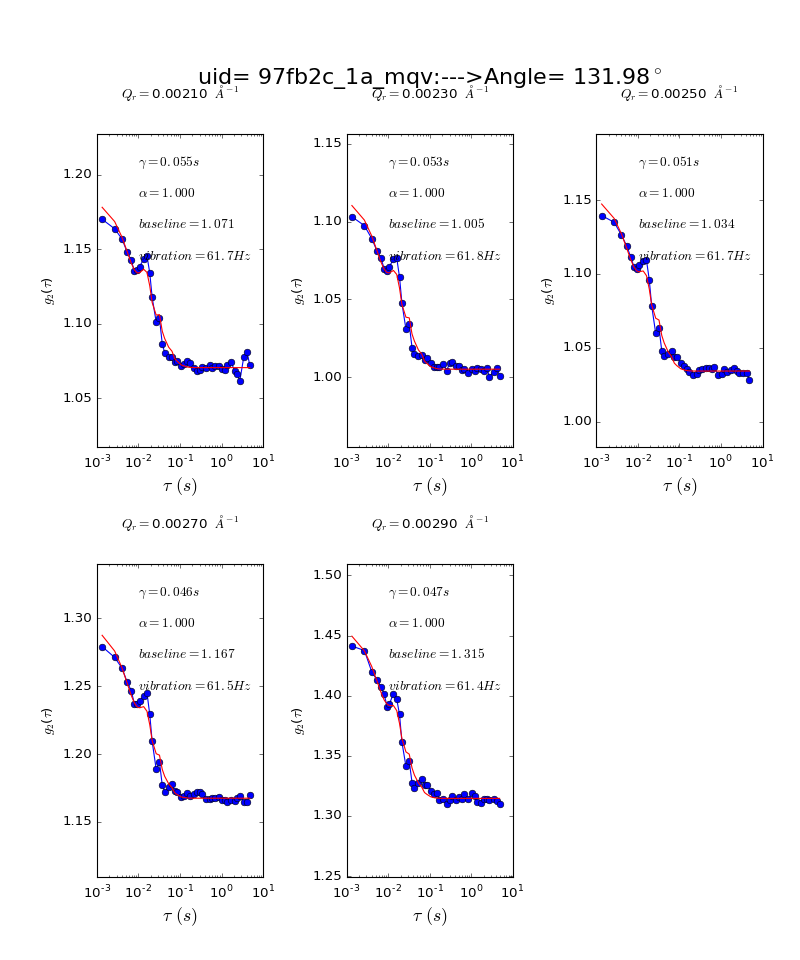

In [361]:
plot_g2( g2v, res_pargs= res_pargsv, tau_2 = tausv_fit, g2_2 = g2v_fit,  
        fit_res= g2v_fit_result, function = 'stretched_vibration',     
        master_plot = 'qz',vlim=[0.95, 1.05], geometry='ang_saxs', append_name='v_fit'  )


In [365]:
dfv = save_g2_fit_para_tocsv(g2v_fit_result, filename= uid +'_1a_mqv_fit_para', path=data_dir ) 

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/97fb2c_1a_mqv_fit_para.csv


In [366]:
dfv

,baseline,relaxation_rate,beta,alpha,freq,amp
0,1.070544,18.212905,0.101192,1.0,61.726101,0.133486
1,1.005181,19.044833,0.099685,1.0,61.798236,0.126460
2,1.034269,19.462705,0.108487,1.0,61.709433,0.113074
3,1.167491,21.817232,0.114326,1.0,61.548810,0.130073
4,1.314596,21.282798,0.129904,1.0,61.430760,0.113911


The fitted diffusion coefficient D0 is:  3.046e+06   A^2S-1


<IPython.core.display.Javascript object>


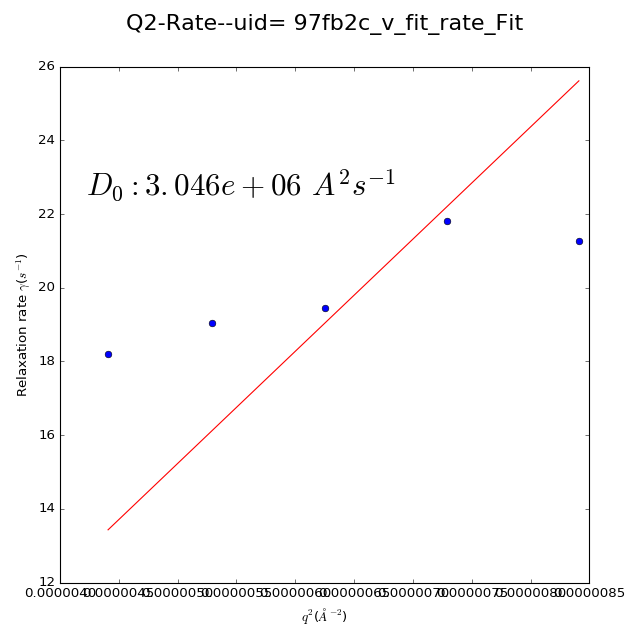

3045840.1619714363

In [379]:
fit_q_rate(  q_ring_center[:],dfv['relaxation_rate'], power_variable= False, 
           uid=uid +'_v_fit_rate', path= data_dir )

# For parallel

In [368]:
w = 2
inner_angle=  42 -  w
outer_angle =  42 + w
num_angles =   1
widtha = (outer_angle - inner_angle )/(num_angles+0.01)
ang_mask_p, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
            outer_angle = outer_angle, width = widtha, 
        num_angles = num_angles, center = center, flow_geometry=True )

inner_radius= 0.002  #16
outer_radius = 0.003  #112
width =  0.0002  #2
num_rings = 5
edges = None   
ring_mask_p, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                unit='A',outer_radius = outer_radius, 
                width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )

seg_mask_p,  rcen, acen = get_ring_anglar_mask( ring_mask_p, ang_mask_p, q_ring_center, ang_center)

In [369]:
t0 = time.time()
g2p, lag_stepsp  =cal_g2p( FD,  seg_mask_p, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--11--
Bad frame involved and will be precessed!
4999 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

G2 calculation DONE!
Total time: 0.09 min


In [371]:
tausp = lag_stepsp * timeperframe
res_pargsp = dict(taus=tausp, q_ring_center=np.unique(rcen), 
                 ang_center= np.unique(acen),  path=data_dir, uid=uid +'_1a_mqp'       )


save_g2( g2p, taus=tausp, qr=rcen, qz=acen, uid=uid +'_1a_mqp', path= data_dir )

if False:
    plot_g2( g2p, res_pargsp, geometry='ang_saxs', master_plot='qz', one_plot= True, vlim=[0.95, 1.05], )

if fit:
    g2p_fit_result, tausp_fit, g2p_fit = get_g2_fit( g2p,  res_pargs=res_pargsp, 
                function = 'stretched_vibration',  vlim=[0.95, 1.05], 
    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                  'freq':True, 'amp':True},
   fit_range= None,                                
    guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,
                 'freq': 60, 'amp':.1})



save_g2( g2p_fit, taus=tausp_fit,qr=rcen, qz=acen, uid=uid +'_1a_mqp_fit', path= data_dir )

res_pargsp_fit = dict(taus=tausp, q_ring_center= q_ring_center, 
                 ang_center= [acen[0]],  path=data_dir, uid=uid +'_1a_mqp_fit'       )
#save_seg_saxs_g2( g2,  res_pargs )

The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/ with filename as uid=97fb2c_1a_mqp--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/ with filename as uid=97fb2c_1a_mqp_fit--g2.csv


<IPython.core.display.Javascript object>


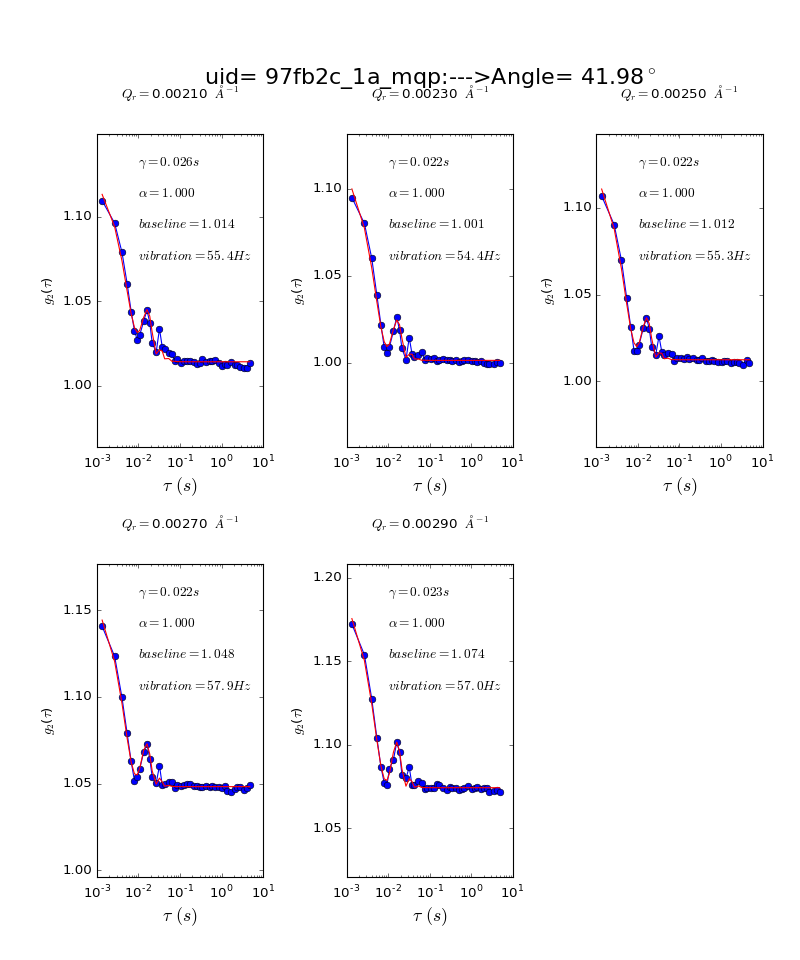

In [372]:
plot_g2( g2p, res_pargs=res_pargsp, tau_2 = tausp_fit, g2_2 = g2p_fit,  
        fit_res=g2p_fit_result, function = 'stretched_vibration',     
        master_plot = 'qz',vlim=[0.95, 1.05], geometry='ang_saxs', append_name='p_fit'  )

In [373]:
dfp = save_g2_fit_para_tocsv(g2p_fit_result, filename= uid +'_1a_mqp_fit_para', path=data_dir ) 

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/97fb2c/97fb2c_1a_mqp_fit_para.csv


In [374]:
dfp

,baseline,relaxation_rate,beta,alpha,freq,amp
0,1.014100,38.033237,0.074538,1.0,55.447128,0.529137
1,1.001343,46.148801,0.067686,1.0,54.413372,0.723384
2,1.012322,45.531277,0.067051,1.0,55.277134,0.739591
3,1.048256,46.443046,0.064558,1.0,57.935980,0.777166
4,1.074401,44.120749,0.064502,1.0,57.009488,0.863908


The fitted diffusion coefficient D0 is:  6.684e+06   A^2S-1


<IPython.core.display.Javascript object>


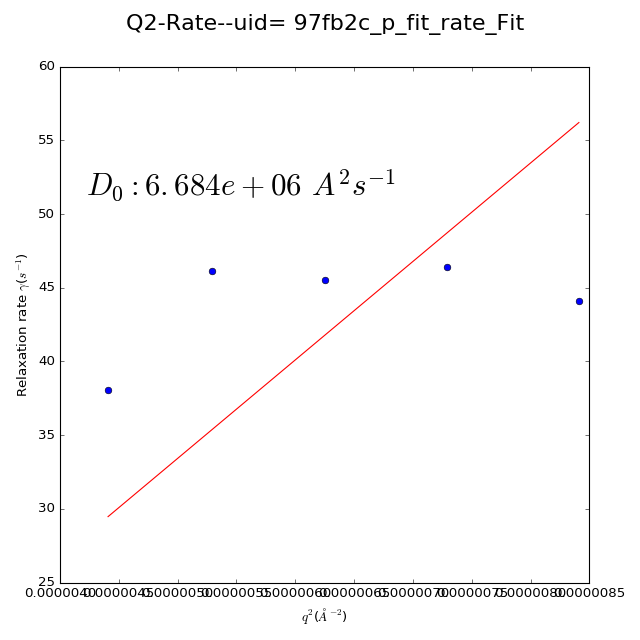

6683796.4427679209

In [380]:
fit_q_rate(  q_ring_center[:],dfp['relaxation_rate'], power_variable= False, 
           uid=uid +'_p_fit_rate', path= data_dir )

# Create a PDF report

In [240]:
create_report = True

In [241]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
print( pdf_out_dir )

/XF11ID/analysis/2016_3/colosqui/Results/


In [396]:
if create_report:
    
    c= create_pdf_report(  data_dir, uid, pdf_out_dir,
                        filename= "XPCS_Analysis_Report_for_uid=%s.pdf"%uid)
    
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=1)
    c.report_meta( top=730)
    c.report_static( top=560, iq_fit =fit_form )
    c.report_ROI( top= 300)
    #Page Two: img~t/iq~t/waterfall/mean~t/g2/rate~q
    c.new_page()
    c.report_header(page=2)
    #c.report_time_analysis( top= 720)    
    #c.report_one_time( top= 350)
    #Page Three: two-time/two g2
    c.report_flow_pv_g2( top= 720)    
    

        
    c.save_page()
    c.done()        



****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/colosqui/Results/XPCS_Analysis_Report_for_uid=97fb2c.pdf
****************************************
